#Определение формата dataset

In [1]:
!pip install chardet

In [2]:
import chardet

In [3]:
# Открываем файл в двоичном режиме и читаем данные
with open('/content/data.csv', 'rb') as file:
    raw_data = file.read()

In [4]:
# Используем chardet для определения кодировки
result = chardet.detect(raw_data)

In [5]:
# Получаем название кодировки
encoding_file = result['encoding']

In [6]:
print(f"Кодировка файла: {encoding_file}")

Кодировка файла: ISO-8859-1


====================================================================

#Подключение библиотек

In [7]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from ipywidgets import interact, widgets
import plotly.graph_objects as go
import plotly.graph_objects as go
from keras.layers import Dropout
from keras.optimizers import SGD
import pickle

#Подготовка датасета

##Загрузка

In [8]:
# Загрузка данных
data = pd.read_csv('/content/data.csv', encoding=encoding_file, delimiter=';')

In [9]:
# Проверка на наличие пустых значений
print(data.isnull().sum())

Datetime             0
Radon (Bq.m3)        9
Temperature (¡C)    55
Pressure (mBar)      0
dtype: int64


In [10]:
# Получение информации о DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8762 entries, 0 to 8761
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Datetime          8762 non-null   object 
 1   Radon (Bq.m3)     8753 non-null   float64
 2   Temperature (¡C)  8707 non-null   object 
 3   Pressure (mBar)   8762 non-null   object 
dtypes: float64(1), object(3)
memory usage: 273.9+ KB


##Подготовка данных

In [11]:
data['Temperature (¡C)'] = data['Temperature (¡C)'].str.replace(',', '.').astype(float)

In [12]:
data['Pressure (mBar)'] = data['Pressure (mBar)'].str.replace(',', '.').astype(float)

In [13]:
# Замена пустых значений средними по каждому столбцу
for column in data.columns:
    # Проверяем, содержит ли столбец числовые данные
    if pd.api.types.is_numeric_dtype(data[column]):
        # Заменяем пустые значения средними, только если столбец числовой
        data[column].fillna(data[column].mean(), inplace=True)
    else:
        # Если столбец не числовой, можно заменить пустые значения другим способом
        # Например, можно использовать наиболее часто встречающееся значение:
        # data[column].fillna(data[column].mode()[0], inplace=True)
        pass  # или пропустить столбец

In [14]:
# Проверка на наличие пустых значений
print(data.isnull().sum())

Datetime            0
Radon (Bq.m3)       0
Temperature (¡C)    0
Pressure (mBar)     0
dtype: int64


In [15]:
data.columns

Index(['Datetime', 'Radon (Bq.m3)', 'Temperature (¡C)', 'Pressure (mBar)'], dtype='object')

In [16]:
data.head()

,Datetime,Radon (Bq.m3),Temperature (¡C),Pressure (mBar)
0,04.05.2020 17:00,22204.0,2.027428,981.284980
1,04.05.2020 18:00,25594.0,0.615326,980.457186
2,04.05.2020 19:00,22204.0,0.113435,980.125557
3,04.05.2020 20:00,23617.0,-0.093737,980.157554
4,04.05.2020 21:00,21357.0,-0.191938,980.463049


##Преобразование во временной ряд

In [17]:
# Преобразование столбца с датой и временем в формат datetime
data['Datetime'] = pd.to_datetime(data['Datetime'], format='%d.%m.%Y %H:%M')

In [18]:
# Установка столбца с датой и временем в качестве индекса
data.set_index('Datetime', inplace=True)


##Подготовка наборов данных

In [19]:
# Разделение данных на наборы
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

In [20]:
# Нормализация данных
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_data)
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

In [21]:
# Создание датасета для обучения RNN
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0]) # Предсказываем только уровень радона
    return np.array(dataX), np.array(dataY)

In [22]:
time_step = 5
X_train, y_train = create_dataset(train_scaled, time_step)

In [23]:
time_step = 5
X_val, y_val = create_dataset(val_scaled, time_step)

In [24]:
time_step = 5
X_test, y_test = create_dataset(test_scaled, time_step)

In [25]:
# Изменение формы входных данных для модели RNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], data.shape[1])


In [26]:
# Изменение формы входных данных для модели RNN
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], data.shape[1])

In [27]:
# Изменение формы входных данных для модели RNN
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], data.shape[1])

#Создание модели

In [28]:
# Создание модели RNN
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50))
model.add(Dense(1))


In [29]:
# Используем SGD как оптимизатор и уменьшаем скорость обучения
sgd = SGD(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=sgd)

In [30]:
# Обучение модели и сохранение истории обучения
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=1, verbose=2)

Epoch 1/20
6696/6696 - 44s - loss: 0.0642 - val_loss: 0.0549 - 44s/epoch - 7ms/step
Epoch 2/20
6696/6696 - 40s - loss: 0.0548 - val_loss: 0.0526 - 40s/epoch - 6ms/step
Epoch 3/20
6696/6696 - 26s - loss: 0.0542 - val_loss: 0.0559 - 26s/epoch - 4ms/step
Epoch 4/20
6696/6696 - 28s - loss: 0.0535 - val_loss: 0.0520 - 28s/epoch - 4ms/step
Epoch 5/20
6696/6696 - 27s - loss: 0.0535 - val_loss: 0.0519 - 27s/epoch - 4ms/step
Epoch 6/20
6696/6696 - 27s - loss: 0.0532 - val_loss: 0.0518 - 27s/epoch - 4ms/step
Epoch 7/20
6696/6696 - 28s - loss: 0.0532 - val_loss: 0.0513 - 28s/epoch - 4ms/step
Epoch 8/20
6696/6696 - 27s - loss: 0.0529 - val_loss: 0.0522 - 27s/epoch - 4ms/step
Epoch 9/20
6696/6696 - 27s - loss: 0.0525 - val_loss: 0.0531 - 27s/epoch - 4ms/step
Epoch 10/20
6696/6696 - 28s - loss: 0.0526 - val_loss: 0.0520 - 28s/epoch - 4ms/step
Epoch 11/20
6696/6696 - 28s - loss: 0.0527 - val_loss: 0.0541 - 28s/epoch - 4ms/step
Epoch 12/20
6696/6696 - 28s - loss: 0.0525 - val_loss: 0.0518 - 28s/epoch 

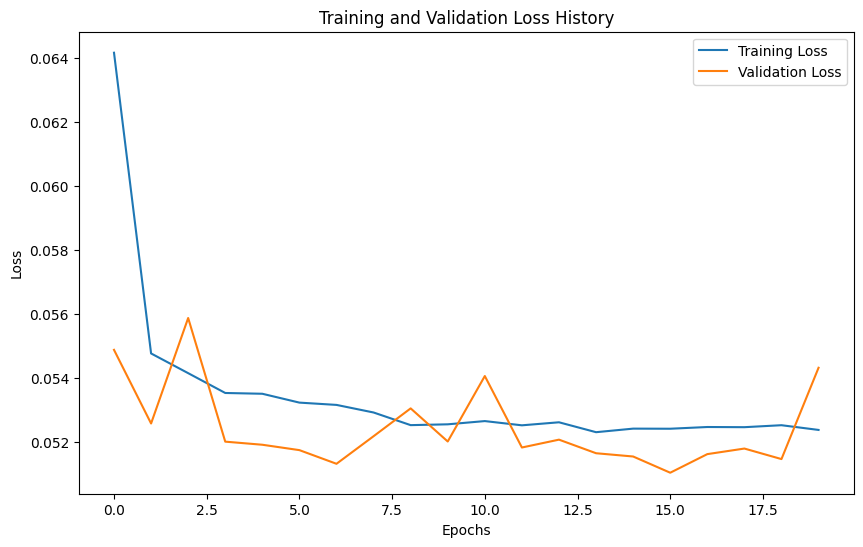

In [31]:
# Визуализация истории обучения
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
model.save('rnn.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
with open('/content/rnn_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

#Тестирование модели

In [34]:
# Оценка модели на тестовом наборе данных
test_performance = model.evaluate(X_test, y_test)
print(f"Тестовая производительность модели: {test_performance}")

28/28 [==============================] - 1s 4ms/step - loss: 0.0552
Тестовая производительность модели: 0.05522642657160759


In [35]:
# Делаем предсказания
def predict_next_timestamp(model, history, time_step):
    last_sequence = np.array(history[-time_step:])
    last_sequence = last_sequence.reshape(1, time_step, data.shape[1])
    prediction = model.predict(last_sequence)
    return prediction

In [36]:
# Предсказание с использованием модели
next_prediction = predict_next_timestamp(model, test_scaled[-time_step:], time_step)

1/1 [==============================] - 0s 437ms/step


In [37]:
# Создаем пустой массив с формой (1, количество_признаков), чтобы соответствовать обученному scaler
prediction_array = np.zeros((1, train_data.shape[1]))
# Помещаем предсказанное значение в столбец, соответствующий Radon
prediction_array[0, 0] = next_prediction

<ipython-input-37-d30bc6e99219>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prediction_array[0, 0] = next_prediction


In [38]:
# Обратное преобразование из нормализованных данных
predicted_value = scaler.inverse_transform(prediction_array)
print(predicted_value[0, 0])  # Выводим только предсказанное значение Radon

19068.921258479357


In [39]:
def plot_data(radon=True, temperature=True, pressure=True):
    plt.figure(figsize=(10,6))

    if radon:
        plt.plot(data['Radon (Bq.m3)'], label='Radon Level')
    if temperature:
        plt.plot(data['Temperature (¡C)'], label='Temperature')
    if pressure:
        plt.plot(data['Pressure (mBar)'], label='Pressure')

    plt.title('Original Time Series Data')
    plt.xlabel('Datetime')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

In [40]:
interact(plot_data,
         radon=widgets.Checkbox(value=True, description='Radon Level'),
         temperature=widgets.Checkbox(value=True, description='Temperature'),
         pressure=widgets.Checkbox(value=True, description='Pressure'))

interactive(children=(Checkbox(value=True, description='Radon Level'), Checkbox(value=True, description='Tempe…

<function __main__.plot_data(radon=True, temperature=True, pressure=True)>

In [41]:
def plot_data(radon=True, temperature=True, pressure=True):
    # Ограничиваем данные до последних 1000 записей
    limited_data = data.tail(10)

    fig = go.Figure()

    if radon:
        fig.add_trace(go.Scatter(y=limited_data['Radon (Bq.m3)'], mode='lines', name='Radon Level'))
    if temperature:
        fig.add_trace(go.Scatter(y=limited_data['Temperature (¡C)'], mode='lines', name='Temperature'))
    if pressure:
        fig.add_trace(go.Scatter(y=limited_data['Pressure (mBar)'], mode='lines', name='Pressure'))

    fig.update_layout(
        title='Interactive Time Series Data',
        xaxis_title='Datetime',
        yaxis_title='Values',
        autosize=False,
        width=1000,
        height=600,
        margin=dict(l=50, r=50, b=100, t=100, pad=4),
        paper_bgcolor="LightSteelBlue",
    )

    fig.show()

interact(plot_data,
         radon=widgets.Checkbox(value=True, description='Radon Level'),
         temperature=widgets.Checkbox(value=True, description='Temperature'),
         pressure=widgets.Checkbox(value=True, description='Pressure'))

interactive(children=(Checkbox(value=True, description='Radon Level'), Checkbox(value=True, description='Tempe…

<function __main__.plot_data(radon=True, temperature=True, pressure=True)>

In [42]:
# Визуализация прогнозируемых значений
# Предполагаем, что 'predicted_value' содержит прогнозируемые значения радона
fig = go.Figure()

# Добавляем линию для фактического уровня радона
fig.add_trace(go.Scatter(x=data.index[-time_step:], y=data['Radon (Bq.m3)'].tail(time_step), mode='lines', name='Actual Radon Level'))

# Добавляем точку для прогнозируемого уровня радона
fig.add_trace(go.Scatter(x=[data.index[-1]], y=[predicted_value[0][0]], mode='markers', name='Predicted Radon Level'))

# Добавляем крест для истинного значения
fig.add_trace(go.Scatter(x=[data.index[-1]], y=[data['Radon (Bq.m3)'].tail(1)], mode='markers', marker_symbol='x', marker_color='red', name='True Radon Level'))

# Добавляем заголовок и подписи осей
fig.update_layout(title='Predicted Radon Level', xaxis_title='Datetime', yaxis_title='Radon (Bq.m3)')

# Отображаем график
fig.show()

In [43]:
# Модифицированная функция для предсказания следующих n значений
def predict_next_n_timestamps(model, history, time_step, n):
    history = np.array(history)
    num_features = history.shape[1]
    predictions = []
    for _ in range(n):
        last_sequence = history[-time_step:]
        last_sequence = last_sequence.reshape(1, time_step, num_features)
        prediction = model.predict(last_sequence)
        predictions.append(prediction[0][0])
        new_row = np.zeros(num_features)
        new_row[0] = prediction[0][0]
        history = np.vstack([history, new_row])
    return predictions

# Предсказание с использованием модели
n = 10  # Количество предсказаний
next_predictions = predict_next_n_timestamps(model, list(test_scaled[-time_step:]), time_step, n)

# Обратное преобразование из нормализованных данных
prediction_array = np.zeros((n, train_data.shape[1]))
prediction_array[:, 0] = next_predictions
predicted_values = scaler.inverse_transform(prediction_array)

# Отображение предсказаний на графике
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Radon (Bq.m3)'], mode='lines', name='Actual Radon Level'))
fig.add_trace(go.Scatter(x=data.index[-n:], y=predicted_values[:, 0], mode='markers', name='Predicted Radon Levels'))
fig.update_layout(title='Predicted Radon Levels', xaxis_title='Datetime', yaxis_title='Radon (Bq.m3)')
fig.show()


1/1 [==============================] - 0s 21ms/step
